# Projet machine learning
## Objectif
Notre objectif est de créer un classifieur permettant de traduire la langue des signes. Pour ce faire, on va se baser sur le dataset [American sign language](https://www.kaggle.com/datasets/ayuraj/asl-dataset) qui répertorie tous les gestes du standard américain de la langue des signes.

On voudrait également pouvoir faire cette traduction pour d'autres langues, par exemple l'arabe grâce à ce dataset [RGB Arabic Alphabets Sign Language Dataset](https://www.kaggle.com/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset), et voire d'autres langues dans le futur. Par ailleurs, on voudrait également pouvoir détecter dans quelle langue un individu parle en langue des signes.

Pour le déploiement, on voudrait faire une sorte de site grâce à streamlit ou gradio, qui pourrait recevoir des images (voire peut être des vidéos si on y arrive), et qui fait la traduction.

## Imports: 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers
import torch
import torch.nn
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
import string
import cv2

OSError: [WinError 126] Le module spécifié est introuvable. Error loading "C:\Users\33769\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\lib\shm.dll" or one of its dependencies.

## Extraction des données 

### Extraction des données V1 :

(400, 400, 3)

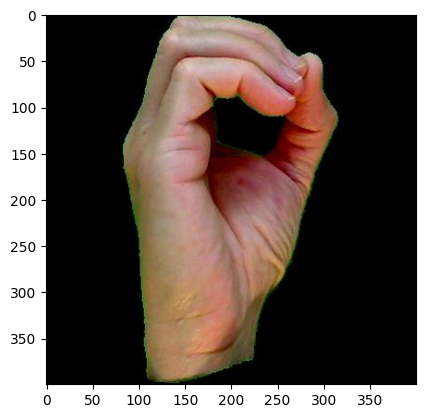

In [88]:
# Example 
img = np.asarray(Image.open('./data/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg'))
imgplot = plt.imshow(img)
img.shape

In [89]:
X_train = []
y_train = []
for dirname, _, filenames in os.walk('./data/asl_dataset/'):
    for filename in filenames:
        y_train.append(dirname[-1])
        X_train.append(np.asarray(Image.open(os.path.join(dirname, filename))))
X_train = np.array(X_train)
y_train = np.array(y_train)

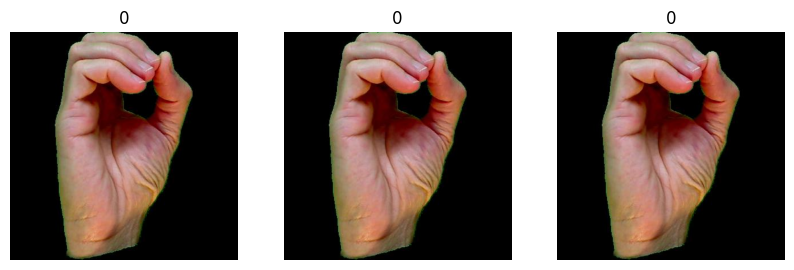

In [90]:
X_test = X_train[:3]
y_test = y_train[:3]
plt.figure(figsize=(10,10))
for images, labels in zip(X_test,y_test): 
    for i in range(3): 
        ax = plt.subplot(1, 3, i+1)
        plt.imshow(images.astype("uint8"))
        plt.title(y_train[i])
        plt.axis("off")

In [91]:
validation_size = int(len(X_train) * 0.5)  # 20% des données pour la validation
# Mélangez les indices du tableau X_train
indices = np.arange(len(X_train))
np.random.seed(42)  # Fixez la graine aléatoire pour la reproductibilité
np.random.shuffle(indices)
# Utilisez les indices mélangés pour obtenir les données mélangées
X_train = X_train[indices]
y_train = y_train[indices]

### Extraction des données V2 :

In [92]:
# Définition du chemin du répertoire contenant les données d'images
path = './data/asl_dataset'

# Chargement du jeu de données d'images à partir du répertoire spécifié
data = tf.keras.preprocessing.image_dataset_from_directory(
    path,  # Chemin du répertoire
    image_size=(64, 64),  # Taille des images (64x64 pixels)
    batch_size=32,  # Taille des lots pour l'entraînement
    validation_split=0.2,  # Fraction des données à utiliser pour la validation (20% ici)
    seed=123,  # Graine pour la reproductibilité
    label_mode='categorical',  # Mode d'encodage des étiquettes ('categorical' pour une classification à plusieurs classes)
    subset="training"  # Sous-ensemble de données à charger (ici, les données d'entraînement)
)


Found 2515 files belonging to 36 classes.
Using 2012 files for training.


In [93]:
# Calcul de la taille de l'ensemble d'entraînement
train_size = int(0.8 * len(data))

# Calcul de la taille de l'ensemble de validation en ajoutant 1 pour s'assurer qu'aucune donnée n'est perdue
val_size = int(0.2 * len(data)) + 1

# Séparation de l'ensemble de données en ensembles d'entraînement et de validation
train_data = data.take(train_size)  # Prend les premiers train_size éléments pour l'ensemble d'entraînement
val_data = data.skip(train_size).take(val_size)  # Saute les éléments d'entraînement et prend val_size éléments pour l'ensemble de validation

# Chargement des données de test en utilisant la fonction image_dataset_from_directory
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    path,  # Chemin du répertoire
    image_size=(64, 64),  # Taille des images (64x64 pixels)
    batch_size=32,  # Taille des lots pour l'entraînement
    validation_split=0.2,  # Fraction des données à utiliser pour la validation (20% ici)
    seed=123,  # Graine pour la reproductibilité
    label_mode='categorical',  # Mode d'encodage des étiquettes ('categorical' pour une classification à plusieurs classes)
    subset="validation"  # Sous-ensemble de données à charger (ici, les données de validation)
)


Found 2515 files belonging to 36 classes.
Using 503 files for validation.


In [94]:
# Définir les étiquettes de classe si elles sont disponibles
class_names = data.class_names if hasattr(data, 'class_names') else None
class_label_mapping = {i: label for i, label in enumerate(string.digits + string.ascii_uppercase)}

#### Visualisation :

In [95]:
def visualisation(image, label, lot, indice): 
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(class_names[tf.argmax(label)]) 
    plt.axis("off")
    plt.show()

## Extraction des embeddings 

### Remarques: 

exemple de création et d'utilisation d'un réseau de neurones convolutionnel : 
lien git : https://github.com/anisayari/Youtube-apprendre-le-deeplearning-avec-tensorflow/blob/master/%234%20-%20CNN/A_deep_introduction_to_CNN%20(1).ipynb

## Réseau de neurones -version 1-

#### Construction du réseau de neurones :

In [96]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(36, activation = 'softmax')
])

# Compilez le modèle
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping( monitor='val_loss', 
                                                   patience=3, 
                                                   mode='min', 
                                                   restore_best_weights=True)

#### Entrainement du réseau de neurones:

In [97]:
history = cnn_model.fit(train_data, epochs=10, 
                    validation_data=val_data, 
                    callbacks=[early_stopping])

Epoch 1/10
50/50 [==============================] - 12s 170ms/step - loss: 2.0928 - accuracy: 0.3988 - val_loss: 0.8499 - val_accuracy: 0.7524
Epoch 2/10
50/50 [==============================] - 8s 163ms/step - loss: 0.5546 - accuracy: 0.8256 - val_loss: 0.3117 - val_accuracy: 0.8908
Epoch 3/10
50/50 [==============================] - 9s 169ms/step - loss: 0.2617 - accuracy: 0.9131 - val_loss: 0.2481 - val_accuracy: 0.9272
Epoch 4/10
50/50 [==============================] - 8s 163ms/step - loss: 0.1854 - accuracy: 0.9525 - val_loss: 0.1829 - val_accuracy: 0.9587
Epoch 5/10
50/50 [==============================] - 8s 169ms/step - loss: 0.1196 - accuracy: 0.9606 - val_loss: 0.1464 - val_accuracy: 0.9636
Epoch 6/10
50/50 [==============================] - 9s 182ms/step - loss: 0.0715 - accuracy: 0.9750 - val_loss: 0.1216 - val_accuracy: 0.9709
Epoch 7/10
50/50 [==============================] - 8s 166ms/step - loss: 0.0403 - accuracy: 0.9837 - val_loss: 0.0748 - val_accuracy: 0.9757
Epoch

## Réseau de neurones -version 2-

#### Construction du réseau de neurones :

In [ ]:
model = models.resnet18(pretrained = True)
embedder = model._modules.get("avgpool")


### Tests

Explication du code : \
La ligne de code `predictions = cnn_model.predict(tf.expand_dims(image_to_predict, axis=0))` est utilisée pour faire une prédiction sur une seule image (`image_to_predict`) à l'aide d'un modèle CNN (`cnn_model`).

- `tf.expand_dims(image_to_predict, axis=0)` est utilisé pour ajouter une dimension supplémentaire à l'image. Cela est nécessaire car le modèle attend des lots d'images, et même lorsqu'une seule image est utilisée, elle doit être présentée comme un lot d'une seule image. L'ajout d'une dimension supplémentaire à l'axe 0 crée un lot contenant une seule image.

- `cnn_model.predict()` est utilisé pour faire une prédiction à partir de l'image étendue. Cette méthode prend en entrée les données d'entrée et renvoie les prédictions du modèle pour ces données.

- `predictions` contient les sorties prédites du modèle pour l'image donnée. Ces sorties peuvent être des probabilités pour chaque classe dans le cas d'une classification, ou d'autres types de sorties en fonction de la tâche du modèle.


1/1 [==============================] - 0s 105ms/step
Classe prédite : S


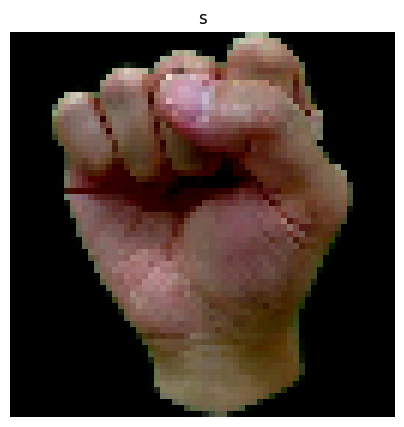

1/1 [==============================] - 0s 26ms/step
Classe prédite : 1


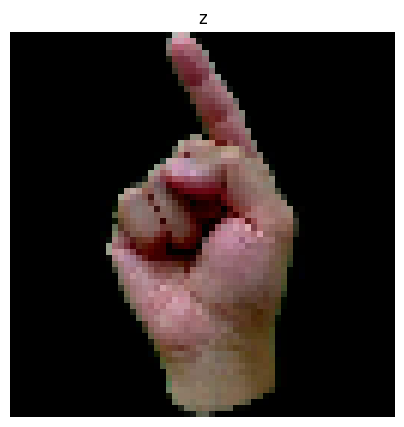

1/1 [==============================] - 0s 25ms/step
Classe prédite : H


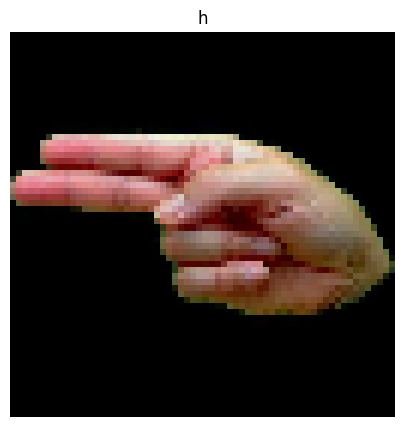

In [98]:
for images, labels in data.take(1):  # Prendre un seul lot d'images
    for i in range(3):  
        image_to_predict = images[i].numpy().astype("uint8")
        # Redimensionner l'image à la taille que le modèle attend
        image_to_predict = tf.image.resize(image_to_predict, (64, 64))

        # Faire la prédiction en utilisant la méthode predict du modèle
        predictions = cnn_model.predict(tf.expand_dims(image_to_predict, axis=0))

        # Trouver l'indice de la classe prédite
        predicted_class_index = tf.argmax(predictions, axis=-1).numpy()[0]

        # Afficher la classe prédite
        predicted_class_label = class_label_mapping[predicted_class_index]
        print("Classe prédite :", predicted_class_label)

        visualisation(images[i].numpy().astype("uint8"), labels[i], 3, i) 

In [99]:
image_to_predict = cv2.imread('./test1_C.jpeg')
# Redimensionner l'image à la taille que le modèle attend
image_to_predict = tf.image.resize(image_to_predict, (64, 64))

# Faire la prédiction en utilisant la méthode predict du modèle
predictions = cnn_model.predict(tf.expand_dims(image_to_predict, axis=0))

# Trouver l'indice de la classe prédite
predicted_class_index = tf.argmax(predictions, axis=-1).numpy()[0]

# Afficher la classe prédite
predicted_class_label = class_label_mapping[predicted_class_index]
print("Classe prédite :", predicted_class_label)


1/1 [==============================] - 0s 30ms/step
Classe prédite : J
